In [95]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [96]:
from google.colab import files
import os

import numpy as np
import cv2
from google.colab.patches import cv2_imshow

import torch 
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
from torchsummary import summary

from tqdm import tqdm

In [98]:
imgHeight = 368
imgWidth = 384

numClasses = 2
directory = '/content/drive/My Drive/Segmentation_Urban_Area/Urban_Area/'

setDirectory = 'Full_set_min/' #training and validation sets
testDirectory = '3_Test_set/'  #test set

pathToTrainInitialSet = directory + setDirectory + 'Initial/'
pathToTrainValidationSet = directory + setDirectory + 'Segmented/'
pathToTestInitialSet = directory + testDirectory + 'Initial/'
pathToTestValidationSet = directory + testDirectory + 'Segmented/'

leaningRate = 0.001
numEpoch = 10
batchSize = 1

In [99]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')
    
def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
      
  def __iter__(self):
    for b in self.dl: 
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [100]:
device = get_default_device()
device

device(type='cuda')

In [101]:
def get_transforms():
  return transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.485, 0.456, 0.406], 
                                 [0.229, 0.224, 0.225]
                                 )
                             ])

class SegmentationDataSet(data.Dataset):
  def __init__(self,
               initial, 
               segmented, 
               pathInitial,
               pathSegmented, 
               transform=None):
    self.initial = initial
    self.segmented = segmented
    self.transform = transform
    self.pathInitial = pathInitial
    self.pathSegmented = pathSegmented

  def __len__(self):
    return len(self.initial)

  def __getitem__(self, 
                  index):
    initial_ID = self.initial[index]
    segmented_ID = self.segmented[index]

    transformToTensor = get_transforms()
    im = cv2.imread(self.pathInitial + initial_ID, 1)
    im = cv2.resize(im, (imgWidth, imgHeight))
    #image = np.moveaxis(im, -1, 0)
    image = im

    # simple ohe
    g = cv2.imread(self.pathSegmented + segmented_ID)
    g = cv2.resize(g, (imgWidth, imgHeight))
    g = cv2.cvtColor(g, cv2.COLOR_BGR2GRAY)
    (_, g) = cv2.threshold(g, 10, 255, cv2.THRESH_BINARY)
    mask = (g > 0).astype(int)

    return image, mask

  def choose(self): return self[np.random.randint(len(self))]
  
  def collate_fn(self, batch):
    ims, masks = list(zip(*batch))
    ims = torch.cat([get_transforms()(im.copy()/255.)[None] for im in ims]).float().to(device)
    ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
    return ims, ce_masks

In [102]:
initialList = sorted(os.listdir(pathToTrainInitialSet))
segmentedList = sorted(os.listdir(pathToTrainValidationSet))

percent = 20
all = len(initialList)
valLength = int(np.floor((all * percent) / 100))
trainLength = all - valLength

trainDataset = SegmentationDataSet(initialList,
                                   segmentedList,
                                   pathToTrainInitialSet,
                                   pathToTrainValidationSet,
                                   transform=None)

trainSet, valSet = data.random_split(trainDataset, [trainLength, valLength])

trainLoader = data.DataLoader(trainSet, batch_size=batchSize, shuffle=False, collate_fn=trainDataset.collate_fn)
valLoader = data.DataLoader(valSet, batch_size=batchSize, shuffle=False, collate_fn=trainDataset.collate_fn)

(368, 384, 3)


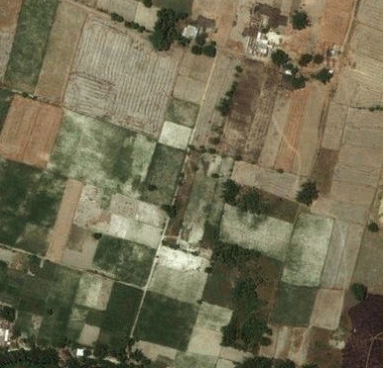

In [103]:
example1 = trainSet[0][0]
shape1 = example1.shape
print(shape1)

cv2_imshow(example1)

(368, 384)


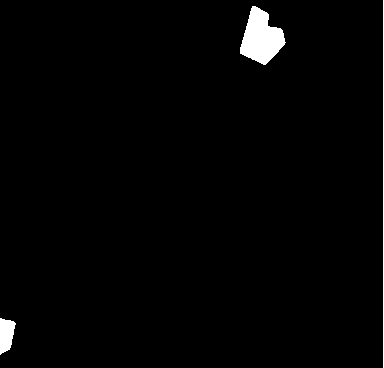

In [104]:
example2 = trainSet[0][1]
shape2 = example2.shape
print(shape2)
cv2_imshow(example2 * 255)

In [105]:
def conv(in_channels, out_channels):
  return nn.Sequential(
    nn.Conv2d(in_channels, 
              out_channels, 
              kernel_size = 3,
              stride = 1,
              padding = 1),
    nn.BatchNorm2d(out_channels),
    nn.ReLU(inplace=True)
  )

def convUp(in_channels, out_channels):
  return nn.Sequential(
    nn.ConvTranspose2d(in_channels, 
                        out_channels, 
                        kernel_size = 2,
                        stride = 2),
    nn.BatchNorm2d(out_channels),
    nn.ReLU(inplace=True)
  )

class UNet(nn.Module):
  def __init__(self, numClasses = numClasses):
    super(UNet, self).__init__()

    self.down1 = nn.Sequential(
        conv(3, 64),
        conv(64, 64)
    )

    self.down2 = nn.Sequential(
        nn.MaxPool2d(kernel_size=2),
        conv(64, 128),
        conv(128, 128)
    )

    self.down3 = nn.Sequential(
        nn.MaxPool2d(kernel_size=2),
        conv(128, 256),
        conv(256, 256),
        conv(256, 256)
    )

    self.fulldown = nn.Sequential(
        nn.MaxPool2d(kernel_size=2),
        conv(256, 512),
        conv(512, 512),
        conv(512, 512)
    )

    self.up11 = convUp(512, 256)
    self.up12 = nn.Sequential(
        conv(512, 256),
        conv(256, 256)
    )

    self.up21 = convUp(256, 128)
    self.up22 = nn.Sequential(
        conv(256, 128),
        conv(128, 128)
    )

    self.up31 = convUp(128, 64)
    self.up32 = nn.Sequential(
        conv(128, 64),
        conv(64, 64)
    )

    self.last = nn.Conv2d(64, numClasses, kernel_size = 1)

  def forward(self, x):
    out1 = self.down1(x)
    out2 = self.down2(out1)
    out3 = self.down3(out2)
    
    out4 = self.fulldown(out3)

    x = self.up11(out4)
    x = torch.cat([x, out3], dim=1)
    x = self.up12(x)

    x = self.up21(x)
    x = torch.cat([x, out2], dim=1)
    x = self.up22(x)

    x = self.up31(x)
    x = torch.cat([x, out1], dim=1)
    x = self.up32(x)

    x = self.last(x)

    return x

In [ ]:
# pretrained

# from torchvision.models import vgg16_bn

# def conv(in_channels, out_channels):
#     return nn.Sequential(
#         nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
#         nn.BatchNorm2d(out_channels),
#         nn.ReLU(inplace=True)
#     )

# def up_conv(in_channels, out_channels):
#     return nn.Sequential(
#         nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
#         nn.ReLU(inplace=True)
#     )

# class UNet(nn.Module):
#     def __init__(self, pretrained=True, out_channels=2):
#         super().__init__()

#         self.encoder = vgg16_bn(pretrained=pretrained).features
#         self.block1 = nn.Sequential(*self.encoder[:6])
#         self.block2 = nn.Sequential(*self.encoder[6:13])
#         self.block3 = nn.Sequential(*self.encoder[13:20])
#         self.block4 = nn.Sequential(*self.encoder[20:27])
#         self.block5 = nn.Sequential(*self.encoder[27:34])

#         self.bottleneck = nn.Sequential(*self.encoder[34:])
#         self.conv_bottleneck = conv(512, 1024)

#         self.up_conv6 = up_conv(1024, 512)
#         self.conv6 = conv(512 + 512, 512)
#         self.up_conv7 = up_conv(512, 256)
#         self.conv7 = conv(256 + 512, 256)
#         self.up_conv8 = up_conv(256, 128)
#         self.conv8 = conv(128 + 256, 128)
#         self.up_conv9 = up_conv(128, 64)
#         self.conv9 = conv(64 + 128, 64)
#         self.up_conv10 = up_conv(64, 32)
#         self.conv10 = conv(32 + 64, 32)
#         self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
        
#     def forward(self, x):
#         block1 = self.block1(x)
#         block2 = self.block2(block1)
#         block3 = self.block3(block2)
#         block4 = self.block4(block3)
#         block5 = self.block5(block4)

#         bottleneck = self.bottleneck(block5)
#         x = self.conv_bottleneck(bottleneck)

#         x = self.up_conv6(x)
#         x = torch.cat([x, block5], dim=1)
#         x = self.conv6(x)

#         x = self.up_conv7(x)
#         x = torch.cat([x, block4], dim=1)
#         x = self.conv7(x)

#         x = self.up_conv8(x)
#         x = torch.cat([x, block3], dim=1)
#         x = self.conv8(x)

#         x = self.up_conv9(x)
#         x = torch.cat([x, block2], dim=1)
#         x = self.conv9(x)

#         x = self.up_conv10(x)
#         x = torch.cat([x, block1], dim=1)
#         x = self.conv10(x)

#         x = self.conv11(x)

#         return x

In [106]:
ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
  ce_loss = ce(preds, targets)
  acc = (torch.max(preds, 1)[1] == targets).float().mean()
  return ce_loss, acc

class engine():
  def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

  @torch.no_grad()
  def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

def make_model():
  model = UNet().to(device)
  criterion = UnetLoss
  optimizer = torch.optim.Adam(model.parameters(), lr = leaningRate)
  return model, criterion, optimizer

model, criterion, optimizer = make_model()  

In [ ]:
summary(model, (3, 368, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 368, 384]           1,792
       BatchNorm2d-2         [-1, 64, 368, 384]             128
              ReLU-3         [-1, 64, 368, 384]               0
            Conv2d-4         [-1, 64, 368, 384]          36,928
       BatchNorm2d-5         [-1, 64, 368, 384]             128
              ReLU-6         [-1, 64, 368, 384]               0
         MaxPool2d-7         [-1, 64, 184, 192]               0
            Conv2d-8        [-1, 128, 184, 192]          73,856
       BatchNorm2d-9        [-1, 128, 184, 192]             256
             ReLU-10        [-1, 128, 184, 192]               0
           Conv2d-11        [-1, 128, 184, 192]         147,584
      BatchNorm2d-12        [-1, 128, 184, 192]             256
             ReLU-13        [-1, 128, 184, 192]               0
        MaxPool2d-14          [-1, 128,

In [107]:
def run():
  for epoch in range(numEpoch):
    print(f"Epoch: {epoch}")
    print()

    for bx, data in tqdm(enumerate(trainLoader), total = len(trainLoader)):
        train_loss, train_acc = engine.train_batch(model, data, optimizer, criterion)

    for bx, data in tqdm(enumerate(valLoader), total = len(valLoader)):
        val_loss, val_acc = engine.validate_batch(model, data, criterion)

    print(epoch, train_loss, train_acc, val_loss, val_acc)
    print()

In [108]:
run()

Epoch: 0



100%|██████████| 10/10 [00:00<00:00, 18.21it/s]


0 0.28561583161354065 0.8889479041099548 0.14619474112987518 0.9415478110313416

Epoch: 1



100%|██████████| 10/10 [00:00<00:00, 18.76it/s]


1 0.20789635181427002 0.9253212809562683 0.09473473578691483 0.9844670295715332

Epoch: 2



100%|██████████| 10/10 [00:00<00:00, 18.19it/s]


2 0.1659165471792221 0.9335300922393799 0.4533461034297943 0.8568133115768433

Epoch: 3



100%|██████████| 10/10 [00:00<00:00, 18.44it/s]


3 0.14747847616672516 0.9395239353179932 0.08115645498037338 0.9795417189598083

Epoch: 4



100%|██████████| 10/10 [00:00<00:00, 18.01it/s]


4 0.14622147381305695 0.9375566244125366 0.06545836478471756 0.9778433442115784

Epoch: 5



100%|██████████| 10/10 [00:00<00:00, 17.95it/s]


5 0.12898673117160797 0.950577437877655 0.06124149635434151 0.9834126234054565

Epoch: 6



100%|██████████| 10/10 [00:00<00:00, 18.09it/s]


6 0.13894835114479065 0.9396300315856934 0.17523746192455292 0.9714037179946899

Epoch: 7



100%|██████████| 10/10 [00:00<00:00, 18.26it/s]


7 0.13419482111930847 0.94333815574646 0.0677257776260376 0.9739088416099548

Epoch: 8



100%|██████████| 10/10 [00:00<00:00, 18.13it/s]


8 0.12620942294597626 0.9456875920295715 0.06222904473543167 0.9751754999160767

Epoch: 9



100%|██████████| 10/10 [00:00<00:00, 18.40it/s]

9 0.12383417040109634 0.9502731561660767 0.07747790962457657 0.9781618118286133



In [109]:
initialTestList = sorted(os.listdir(pathToTestInitialSet))
segmentedTestList = sorted(os.listdir(pathToTestValidationSet))

testDataset = SegmentationDataSet(initialTestList,
                                   segmentedTestList,
                                   pathToTestInitialSet,
                                   pathToTestValidationSet,
                                   transform=None)

testLoader = data.DataLoader(testDataset, batch_size=batchSize, shuffle=False, collate_fn=testDataset.collate_fn)

In [110]:
x, y = next(iter(testLoader))

model.eval()
res = model(x)

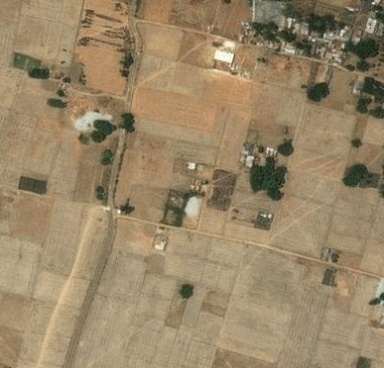

In [111]:
cv2_imshow(testDataset[0][0])

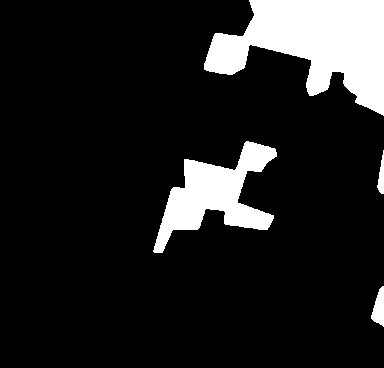

In [112]:
cv2_imshow(testDataset[0][1] * 255)

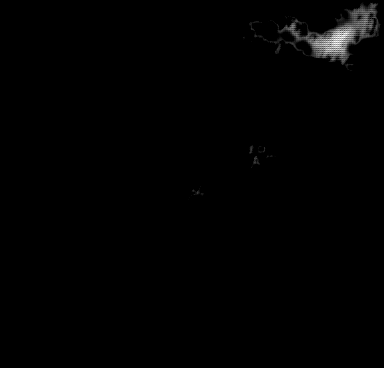

In [115]:
pred = res.data[0][1].cpu().numpy()
cv2_imshow(pred * 255)

In [116]:
torch.save(model.state_dict(), directory + 'model.pth')